In [8]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import networkx as nx
from urllib.request import urlretrieve
import os
from network_deconvolution import network_deconvolution


def load_datasets():
    """加载并处理多个数据集,生成邻接矩阵并保存"""
    # # 处理CORA数据集
    # cora_dir = "cora"
    # if os.path.exists(cora_dir):
    #     cora_citations = pd.read_csv(os.path.join(cora_dir, "cora.cites"), sep='\t', names=['cited_paper', 'citing_paper'])
    #     cora_content = pd.read_csv(os.path.join(cora_dir, "cora.content"), sep='\t', header=None)
    #     cora_papers = cora_content[0]
    #     cora_adj = create_adj_matrix(cora_papers, cora_citations)
    #     np.save(os.path.join(cora_dir, 'adj_matrix.npy'), cora_adj)
    # # 处理Polbooks数据集
    # polbooks_dir = "polbooks"
    # if os.path.exists(polbooks_dir):
    #     G = nx.read_gml(os.path.join(polbooks_dir, "polbooks.gml"))
    #     polbooks_adj = nx.to_numpy_array(G)
    #     np.save(os.path.join(polbooks_dir, 'adj_matrix.npy'), polbooks_adj)

    # # 处理Citeseer数据集  cora与citeseer数据集的content结构不同   Citeseer 的 content 文件中包含不同类型的数据（字符串ID和数值特征）
    # citeseer_dir = "citeseer" 
    # if os.path.exists(citeseer_dir):
    #     citeseer_citations = pd.read_csv(os.path.join(citeseer_dir, "citeseer.cites"), 
    #                                    sep='\t', 
    #                                    names=['cited_paper', 'citing_paper'])
    #     citeseer_content = pd.read_csv(os.path.join(citeseer_dir, "citeseer.content"), 
    #                                  sep='\t', 
    #                                  header=None,
    #                                  low_memory=False)  # 添加low_memory参数为false  pandas会会一次性读取整个文件，避免类型推断的不一致性
    #     citeseer_papers = citeseer_content[0]
    #     citeseer_adj = create_adj_matrix(citeseer_papers, citeseer_citations)
    #     np.save(os.path.join(citeseer_dir, 'adj_matrix.npy'), citeseer_adj)

    # # 处理Pubmed数据集
    # pubmed_dir = "pubmed"
    # if os.path.exists(pubmed_dir):
    #     try:
    #         # 读取引用关系数据
    #         pubmed_citations = pd.read_csv(
    #             os.path.join(pubmed_dir, "Pubmed-Diabetes.DIRECTED.cites.tab"),
    #             sep='\t', 
    #             skiprows=3,  # 跳过前3行头部信息
    #             names=['index', 'citing_paper', 'separator', 'cited_paper']
    #         )
    #         # 清理数据
    #         pubmed_citations['citing_paper'] = pubmed_citations['citing_paper'].str.replace('paper:', '')
    #         pubmed_citations['cited_paper'] = pubmed_citations['cited_paper'].str.replace('paper:', '')
    #         pubmed_citations = pubmed_citations[['citing_paper', 'cited_paper']]
            
    #         # 获取所有唯一的论文ID
    #         all_papers = pd.concat([
    #             pubmed_citations['citing_paper'],
    #             pubmed_citations['cited_paper']
    #         ]).unique()
            
    #         # 创建论文ID的Series
    #         pubmed_papers = pd.Series(all_papers)
            
    #         # 生成邻接矩阵
    #         pubmed_adj = create_adj_matrix(pubmed_papers, pubmed_citations)
            
    #         # 保存邻接矩阵
    #         np.save(os.path.join(pubmed_dir, 'adj_matrix.npy'), pubmed_adj)
    #         print(f"成功保存Pubmed邻接矩阵,形状为: {pubmed_adj.shape}")
            
    #     except Exception as e:
    #         print(f"处理Pubmed数据集时出错: {str(e)}")
    # # 处理Football数据集
    # football_dir = "football"
    # if os.path.exists(football_dir):
    #     G = nx.read_gml(os.path.join(football_dir, "football.gml"))
    #     football_adj = nx.to_numpy_array(G)
    #     np.save(os.path.join(football_dir, 'adj_matrix.npy'), football_adj)
    # 处理Zachary's Karate Club数据集
    karate_dir = "karate"
    if os.path.exists(karate_dir):
        # 从mtx文件读取数据
        with open(os.path.join(karate_dir, "soc-karate.mtx")) as f:
            # 跳过注释行
            while True:
                line = f.readline()
                if not line.startswith('%'):
                    break
            # 读取节点数和边数
            n, _, _ = map(int, line.split())
            # 初始化邻接矩阵
            karate_adj = np.zeros((n, n))
            # 读取边的信息并填充邻接矩阵
            for line in f:
                i, j = map(lambda x: int(x)-1, line.split()[:2])
                karate_adj[i,j] = 1
                karate_adj[j,i] = 1  # 无向图
        np.save(os.path.join(karate_dir, 'adj_matrix.npy'), karate_adj)


def create_adj_matrix(papers, citations):
    """
    创建邻接矩阵
    
    参数:
        papers: 包含所有论文ID的Series
        citations: 包含引用关系的DataFrame，有'cited_paper'和'citing_paper'两列
    
    返回:
        adj_matrix: numpy数组形式的邻接矩阵
    """
    # 创建论文ID到索引的映射
    paper_to_idx = {paper: idx for idx, paper in enumerate(papers)}
    
    # 初始化邻接矩阵
    n_papers = len(papers)
    adj_matrix = np.zeros((n_papers, n_papers))
    
    # 填充邻接矩阵
    for _, row in citations.iterrows():
        try:
            citing_idx = paper_to_idx[row['citing_paper']]
            cited_idx = paper_to_idx[row['cited_paper']]
            # 设置为无向图（双向连接）
            adj_matrix[citing_idx, cited_idx] = 1
            adj_matrix[cited_idx, citing_idx] = 1
        except KeyError:
            # 跳过在papers列表中不存在的引用关系
            continue
    
    return adj_matrix


load_datasets()

In [9]:
def save_labels():
    """保存各个数据集的标签信息"""
    for dataset in ['cora', 'citeseer', 'pubmed', 'football', 'polbooks', 'karate']:
        print(f"\n处理{dataset}数据集...")
        try:
            if not os.path.exists(dataset):
                print(f"警告：{dataset}目录不存在")
                continue
                
            if dataset == 'cora':
                # 确保文件存在
                content_file = os.path.join(dataset, 'cora.content')
                if not os.path.isfile(content_file):
                    print(f"错误：找不到文件 {content_file}")
                    continue
                    
                cora_labels = pd.read_csv(content_file, sep='\t', header=None).iloc[:, -1]
                unique_labels = cora_labels.unique()
                label_dict = {label: i for i, label in enumerate(unique_labels)}
                numeric_labels = np.array([label_dict[label] for label in cora_labels])
                np.save(os.path.join(dataset, 'labels.npy'), numeric_labels)
                print(f"成功保存{dataset}标签，共{len(unique_labels)}个类别")
                
            elif dataset == 'citeseer':
                content_file = os.path.join(dataset, 'citeseer.content')
                if not os.path.isfile(content_file):
                    print(f"错误：找不到文件 {content_file}")
                    continue
                    
                citeseer_labels = pd.read_csv(content_file, sep='\t', header=None).iloc[:, -1]
                unique_labels = citeseer_labels.unique()
                label_dict = {label: i for i, label in enumerate(unique_labels)}
                numeric_labels = np.array([label_dict[label] for label in citeseer_labels])
                np.save(os.path.join(dataset, 'labels.npy'), numeric_labels)
                print(f"成功保存{dataset}标签，共{len(unique_labels)}个类别")

            elif dataset == 'pubmed':
                label_file = os.path.join(dataset, 'Pubmed-Diabetes.NODE.paper.tab')
                if not os.path.isfile(label_file):
                    print(f"错误：找不到文件 {label_file}")
                    continue
                    
                try:
                    labels = []
                    with open(label_file, 'r', encoding='utf-8') as f:
                        header = next(f)  # 跳过头部行
                        for line in f:
                            if line.strip():  # 确保不是空行
                                parts = line.strip().split('\t')
                                # 在每行中寻找包含"label="的字段
                                for part in parts:
                                    if 'label=' in part:
                                        label = int(part.split('label=')[1])
                                        labels.append(label)
                                        break
                    
                    labels = np.array(labels)
                    unique_labels = np.unique(labels)
                    print(f"找到的标签值:", unique_labels)
                    print(f"标签总数:", len(labels))
                    print(f"各标签的数量:")
                    for label in unique_labels:
                        count = np.sum(labels == label)
                        print(f"标签 {label}: {count} 个")
                    
                    np.save(os.path.join(dataset, 'labels.npy'), labels)
                    print(f"成功保存{dataset}标签，共{len(unique_labels)}个类别")
                    
                except Exception as e:
                    print(f"处理{dataset}数据集时出错:", str(e))
                    continue

            elif dataset in ['football', 'polbooks']:
                gml_file = os.path.join(dataset, f'{dataset}.gml')
                if not os.path.isfile(gml_file):
                    print(f"错误：找不到文件 {gml_file}")
                    continue
                    
                G = nx.read_gml(gml_file)
                labels = [G.nodes[node]['value'] for node in G.nodes()]
                
                if dataset == 'polbooks':
                    label_map = {'c': 0, 'n': 1, 'l': 2}
                    labels = [label_map[label] for label in labels]
                    
                np.save(os.path.join(dataset, 'labels.npy'), np.array(labels))
                print(f"成功保存{dataset}标签")
                
            elif dataset == 'karate':
                # Zachary空手道俱乐部数据集有两个社团
                labels = np.zeros(34, dtype=int)
                # 根据历史分裂结果设置标签:0表示教练一方,1表示管理员一方
                labels[0:8] = 0  # 教练一方的成员
                labels[8:] = 1   # 管理员一方的成员
                np.save(os.path.join(dataset, 'labels.npy'), labels)
                print(f"成功保存{dataset}标签，共2个类别")
                
        except Exception as e:
            print(f"处理{dataset}数据集时出错: {str(e)}")
            print(f"错误类型: {type(e).__name__}")
            continue



处理cora数据集...
成功保存cora标签，共7个类别

处理citeseer数据集...


C:\Users\dyh\AppData\Local\Temp\ipykernel_127632\3260030679.py:30: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  citeseer_labels = pd.read_csv(content_file, sep='\t', header=None).iloc[:, -1]


成功保存citeseer标签，共6个类别

处理pubmed数据集...
找到的标签值: [1 2 3]
标签总数: 19717
各标签的数量:
标签 1: 4103 个
标签 2: 7875 个
标签 3: 7739 个
成功保存pubmed标签，共3个类别

处理football数据集...
成功保存football标签

处理polbooks数据集...
成功保存polbooks标签

处理karate数据集...
成功保存karate标签，共2个类别


In [10]:
#  数据集信息汇总： 
#  football ： 关于足球的数据集，代表了某一次的比赛安排，共115个节点表示每个球队，节点按照地理位置分为12个球队会议，
#  如果两个球队之间进行了比赛，就会有一条边连接，共613条边    12个会议形成了自然的社区 
#  Cora:  机器学习论文的引用网络，2708个节点，每个节点表示一篇论文，5429条边表示引用关系，每个节点有1433维的特征向量，是词袋表示， 
#  每个节点属于7个类别之一（论文主题）
#  Citeseer： 来自citeseer图书馆的文献引用网络，3312个节点（论文），4732条边（引用关系），每个节点3703维的特征向量，分为6个类别
#  Pubmed： 来自pubmed的文献引用网络，19717个节点（论文），44338条边（引用关系），每个节点500维的特征向量，分为3个类别
#  Polbooks：2004年美国总统大选期间亚马逊网站上的政治书籍购买网络 105个节点（表示书籍），边441条表示共同购买关系，分为保守派、自由派
#  中立派 3种类别  注意与 polboks 区分 后一个是政治博客数据集 
#  Zachary's Karate Club（空手道俱乐部）
#  节点数：34 表示俱乐部成员
#  边数：78   2个标签，表示成员在俱乐部分裂后追随的两名教练 
# 

import numpy as np
datasets = ['cora', 'citeseer', 'pubmed', 'football', 'polbooks', 'karate'] # citeseer的边数可能不对

for dataset in datasets:
    # 加载邻接矩阵
    adj_matrix = np.load(f'{dataset}/adj_matrix.npy')
    print(f"\n{dataset.upper()} 统计信息:")
    # 1. 查看矩阵基本信息
    print(f"矩阵形状: {adj_matrix.shape}")
    print(f"矩阵类型: {adj_matrix.dtype}")

    # 2. 查看矩阵的一小部分
    print("\n矩阵的前5x5部分:")
    print(adj_matrix[:5, :5])

    # 3. 查看一些基本统计信息
    print(f"\n非零元素数量: {np.count_nonzero(adj_matrix)}")
    print(f"最大值: {np.max(adj_matrix)}")
    print(f"最小值: {np.min(adj_matrix)}")

    # 4. 如果想查看是否为对称矩阵
    is_symmetric = np.allclose(adj_matrix, adj_matrix.T)
    print(f"\n是否为对称矩阵: {is_symmetric}")


CORA 统计信息:
矩阵形状: (2708, 2708)
矩阵类型: float64

矩阵的前5x5部分:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

非零元素数量: 10556
最大值: 1.0
最小值: 0.0

是否为对称矩阵: True

CITESEER 统计信息:
矩阵形状: (3312, 3312)
矩阵类型: float64

矩阵的前5x5部分:
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

非零元素数量: 9196
最大值: 1.0
最小值: 0.0

是否为对称矩阵: True

PUBMED 统计信息:
矩阵形状: (19717, 19717)
矩阵类型: float64

矩阵的前5x5部分:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

非零元素数量: 88649
最大值: 1.0
最小值: 0.0

是否为对称矩阵: True

FOOTBALL 统计信息:
矩阵形状: (115, 115)
矩阵类型: float64

矩阵的前5x5部分:
[[0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]

非零元素数量: 1226
最大值: 1.0
最小值: 0.0

是否为对称矩阵: True

POLBOOKS 统计信息:
矩阵形状: (105, 105)
矩阵类型: float64

矩阵的前5x5部分:
[[0. 1. 1. 1. 1.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]]

非零元素数量: 882
最大值: 1.0
最小值: 0.0

是否为对称矩阵: True

KARATE 统计信息

In [11]:
import numpy as np
import os
def add_noise_to_network(dataset, noise_ratio=0.1):
    """为无向图邻接矩阵添加噪声
    
    参数:
        dataset: str, 数据集名称
        noise_ratio: float, 要添加和删除的噪声边比例，相对于现有边数
        
    返回:
        np.ndarray: 添加噪声后的邻接矩阵
    """
    noisy_matrix = np.load(f'{dataset}/adj_matrix.npy')
    # 复制原始矩阵
    noisy_matrix = adj_matrix.copy()
    n = len(adj_matrix)
    
    # 获取上三角矩阵的索引(因为是无向图)
    triu_indices = np.triu_indices(n, k=1)
    
    # 获取现有边的索引
    existing_edges = np.where(adj_matrix[triu_indices] > 0)[0]
    non_existing_edges = np.where(adj_matrix[triu_indices] == 0)[0]
    
    # 计算要添加和删除的边数
    num_existing = len(existing_edges)
    num_to_add = int(num_existing * noise_ratio)
    num_to_remove = int(num_existing * noise_ratio)
    
    # 随机选择要删除的边
    edges_to_remove = np.random.choice(existing_edges, num_to_remove, replace=False)
    
    # 随机选择要添加的边
    edges_to_add = np.random.choice(non_existing_edges, num_to_add, replace=False)
    
    # 删除边
    for idx in edges_to_remove:
        i, j = triu_indices[0][idx], triu_indices[1][idx]
        noisy_matrix[i,j] = noisy_matrix[j,i] = 0
        
    # 添加边
    for idx in edges_to_add:
        i, j = triu_indices[0][idx], triu_indices[1][idx]
        noisy_matrix[i,j] = noisy_matrix[j,i] = 1
        
    # 保存带噪声的邻接矩阵到对应数据集文件夹
    np.save(f'{dataset}/adj_matrix_{noise_ratio}', noisy_matrix)
        
    return noisy_matrix

datasets = ['cora', 'citeseer', 'football', 'polbooks', 'karate']
# 测试代码
for dataset in datasets:
    adj_matrix = np.load(f'{dataset}/adj_matrix.npy')
    noisy_adj = add_noise_to_network(dataset, noise_ratio=0.1)
    
    print(f"\n{dataset.upper()} 噪声添加结果:")
    print(f"原始边数: {np.sum(adj_matrix)/2}")  # 除以2因为是无向图
    print(f"添加噪声后边数: {np.sum(noisy_adj)/2}")




CORA 噪声添加结果:
原始边数: 5278.0
添加噪声后边数: 5278.0

CITESEER 噪声添加结果:
原始边数: 4598.0
添加噪声后边数: 4598.0

FOOTBALL 噪声添加结果:
原始边数: 613.0
添加噪声后边数: 613.0

POLBOOKS 噪声添加结果:
原始边数: 441.0
添加噪声后边数: 441.0

KARATE 噪声添加结果:
原始边数: 78.0
添加噪声后边数: 78.0



CORA 社团检测结果:


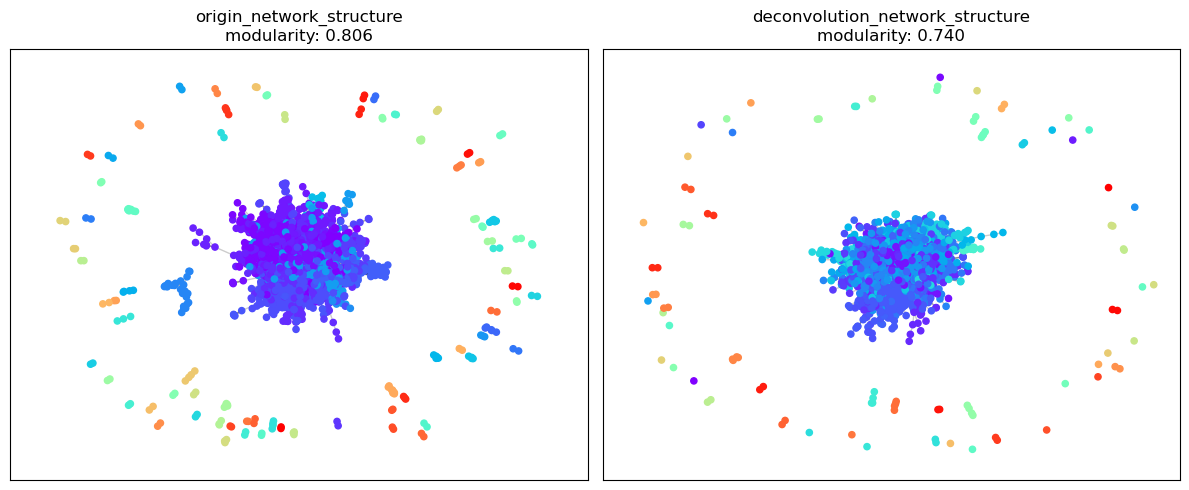

原始网络社团数量: 91
解卷积后网络社团数量: 79
原始网络的模块度：0.806
解卷积后网络的模块度：0.740
原始网络NMI: 0.477
解卷积后网络NMI: 0.323

CITESEER 社团检测结果:


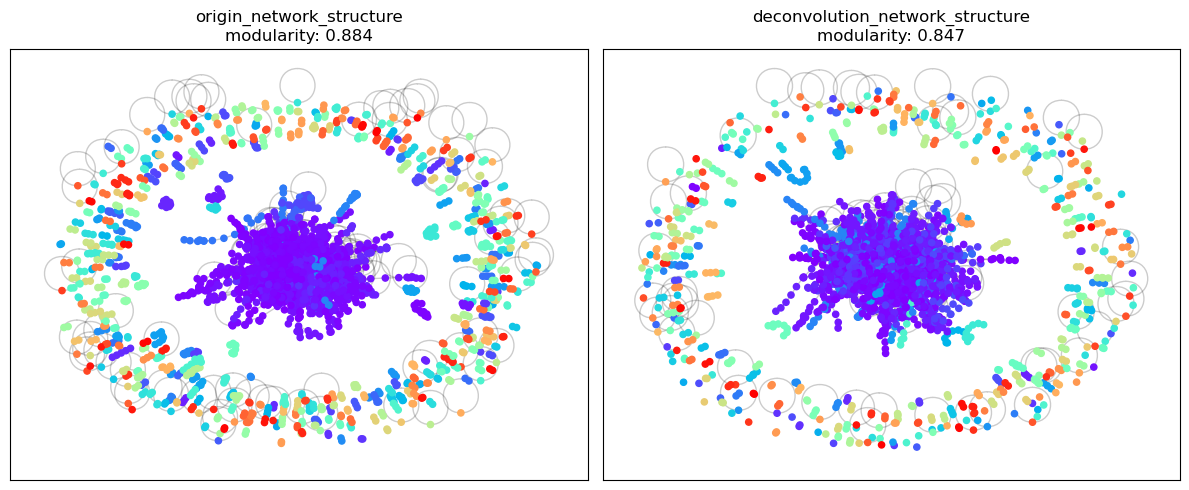

原始网络社团数量: 456
解卷积后网络社团数量: 390
原始网络的模块度：0.884
解卷积后网络的模块度：0.847
原始网络NMI: 0.338
解卷积后网络NMI: 0.230

FOOTBALL 社团检测结果:


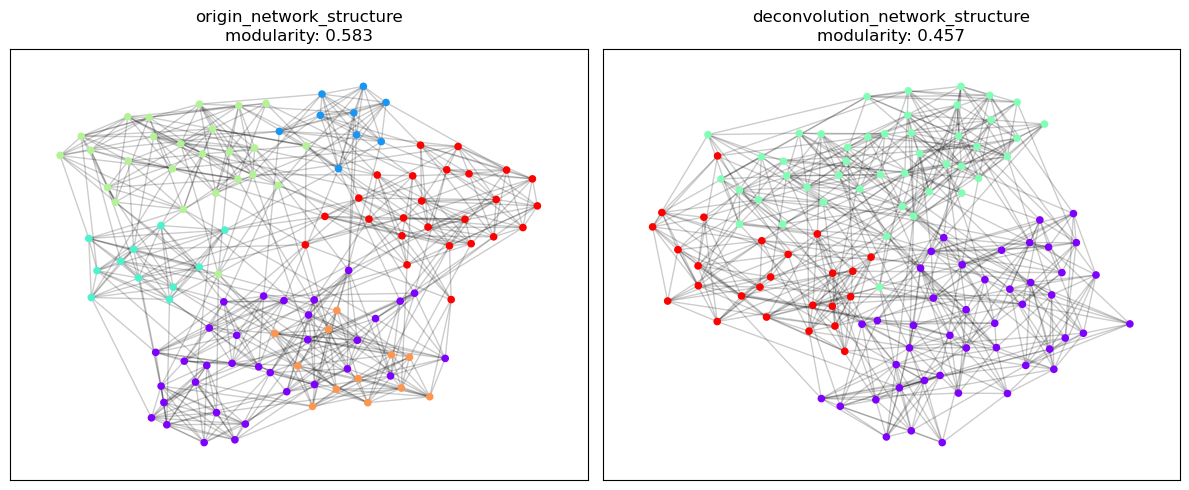

原始网络社团数量: 6
解卷积后网络社团数量: 3
原始网络的模块度：0.583
解卷积后网络的模块度：0.457
原始网络NMI: 0.755
解卷积后网络NMI: 0.526

POLBOOKS 社团检测结果:


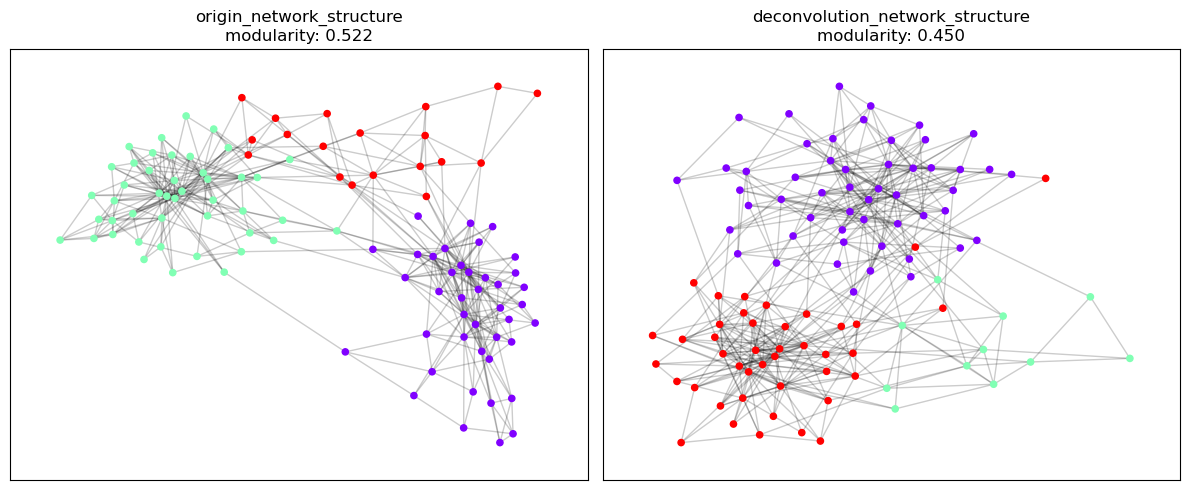

原始网络社团数量: 3
解卷积后网络社团数量: 3
原始网络的模块度：0.522
解卷积后网络的模块度：0.450
原始网络NMI: 0.554
解卷积后网络NMI: 0.542

KARATE 社团检测结果:


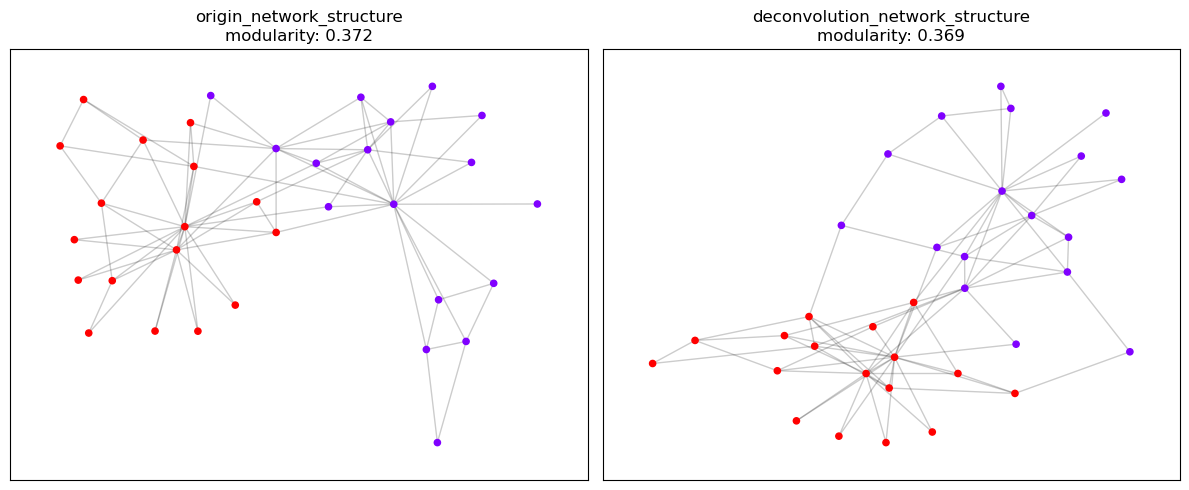

原始网络社团数量: 2
解卷积后网络社团数量: 2
原始网络的模块度：0.372
解卷积后网络的模块度：0.369
原始网络NMI: 0.323
解卷积后网络NMI: 0.323


In [12]:

# 测试带噪声数据集的社团检测效果
import matplotlib.pyplot as plt
from tools import analyze_results
datasets = ['cora', 'citeseer', 'football', 'polbooks', 'karate']
for dataset in datasets:
    print(f"\n{dataset.upper()} 社团检测结果:")
    
    # 加载原始邻接矩阵和带噪声的邻接矩阵
    adj_matrix = np.load(f'{dataset}/adj_matrix.npy')
    noisy_adj = np.load(f'{dataset}/adj_matrix_0.1.npy')
    labels = np.load(f'{dataset}/labels.npy')
    
    # 分析并可视化结果
    original_communities, noisy_communities = analyze_results(adj_matrix, noisy_adj, labels)
